In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/qspright/")
sys.path.append("src")
sys.path.append("src/rna_transform")

import rna_transform.utils as utils
import rna_transform.rna_utils as rna_utils
from rna_transform.rna_utils import calculate_rna_qspright
from qspright.utils import dec_to_qary_vec
import itertools

In [2]:
import os
import ipyparallel as ipp
import time

mycluster = ipp.Cluster(n = int(os.getenv('SLURM_CPUS_ON_NODE')))
mycluster.start_cluster_sync()

c = mycluster.connect_client_sync()
c.wait_for_engines(n = int(os.getenv('SLURM_CPUS_ON_NODE')))
c.ids

dview = c[:]
# Cause execution on main process to wait while tasks sent to workers finish
dview.block = True   

Using existing profile dir: '/global/home/users/erginbas/.ipython/profile_default'
Starting 20 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 20/20 [00:06<00:00,  2.98engine/s]


In [18]:
q = 4
positions = rna_utils.RNA_POSITIONS

# positions = positions[:8]
# rna_utils.RNA_POSITIONS = positions

n = len(positions)

print("n = {}, N = {}".format(n, q ** n))

n = 8, N = 65536


### get Lasso coefficients

In [3]:
# emp_beta_lasso = rna_utils.calculate_rna_lasso(save=True)

In [4]:
# Calculate fraction of variance explained by empirical coefficients
# bm_fv_lasso = utils.calc_frac_var_explained(emp_beta_lasso)

### get GWHT coefficients

In [4]:
emp_beta_gwht = rna_utils.calculate_rna_gwht(save=True)
print(emp_beta_gwht)

Loaded saved beta array for GWHT.
[ 0.00000000e+00-0.00000000e+00j  5.41488694e-02-6.32691955e-01j
  6.73477172e-01-0.00000000e+00j ...  2.15147680e-04-6.25617686e-05j
 -1.86157238e-04-1.00708858e-04j  8.69748765e-05-4.01305559e-04j]


In [5]:
# Calculate fraction of variance explained by empirical coefficients
bm_fv_gwht = utils.calc_frac_var_explained(emp_beta_gwht)

### get GWHT coefficients with QSPRIGHT

In [6]:
num_subsample = 2
num_random_delays = 10
b = 4
gwht, (n_used, n_used_unique), peeled = rna_utils.calculate_rna_qspright(save=False, report = True, num_subsample = num_subsample, num_random_delays = num_random_delays, b = b)
emp_beta_qspright = np.reshape(gwht, -1)
print("total sample ratio = ", n_used / q ** n)
print("unique sample ratio = ", n_used_unique / q ** n)
print("found sparsity = ", np.sum(np.abs(emp_beta_qspright) > 1e-5))
print("NMSE = ", np.sum(np.abs(emp_beta_gwht - emp_beta_qspright)**2) / np.sum(np.abs(emp_beta_gwht)**2))

total sample ratio =  0.703125
unique sample ratio =  0.515625
found sparsity =  111
NMSE =  0.16839757415566364


In [7]:
# Calculate fraction of variance explained by empirical coefficients
bm_fv_qspright = utils.calc_frac_var_explained(emp_beta_qspright)

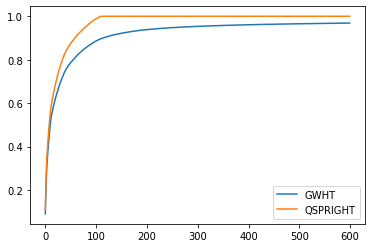

In [8]:
# plt.plot(bm_fv_lasso[:300], label = "Fourier")
plt.plot(bm_fv_gwht[:600], label = "GWHT")
plt.plot(bm_fv_qspright[:600], label = "QSPRIGHT")
plt.legend()
plt.show()

### run parallelized tests

In [57]:
iters = 10
num_subsample_list = [2, 3, 4]
num_random_delays_list = [3, 5, 7]
b_list = [4, 5, 6]
test_params_list = list(itertools.product(num_subsample_list, num_random_delays_list, b_list))

def gwht_test(i):
    param_idx = i % len(test_params_list)
    test_params = test_params_list[param_idx]
    num_subsample, num_random_delays, b = test_params
    gwht, (n_used, n_used_unique), peeled = calculate_rna_qspright(save=False, report = True, num_subsample = num_subsample, num_random_delays = num_random_delays, b = b)
    emp_beta_qspright = np.reshape(gwht, -1)
    sample_ratio = n_used / q ** n
    unique_sample_ratio = n_used_unique/ q ** n
    nmse = np.sum(np.abs(emp_beta_gwht - emp_beta_qspright)**2) / np.sum(np.abs(emp_beta_gwht)**2)
    return param_idx, sample_ratio, unique_sample_ratio, nmse

In [58]:
dview.execute('import numpy as np')
dview.execute('import sys')
dview.execute('sys.path.append("src")')
dview.execute('sys.path.append(".")')
dview.execute('sys.path.append("../src/qspright")')

mydict = dict(test_params_list = test_params_list, calculate_rna_qspright = calculate_rna_qspright, gwht_test = gwht_test, q=q, n=n, emp_beta_gwht = emp_beta_gwht)
dview.push(mydict)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [59]:
def test_wrapper(i):
    return gwht_test(i) 

In [60]:
exp_count = iters * len(test_params_list)

time.time()
# Run a parallel map, executing the wrapper function on indices 0,...,n-1
lview = c.load_balanced_view()
# Cause execution on main process to wait while tasks sent to workers finish
lview.block = True 
pred = lview.map(test_wrapper, range(exp_count))   # Run calculation in parallel
time.time()

1653957396.9045026

In [61]:
test_params_idx_list = list(itertools.product(np.arange(len(num_subsample_list)), np.arange(len(num_random_delays_list)), np.arange(len(b_list))))

sample_ratios = np.zeros((len(num_subsample_list), len(num_random_delays_list), len(b_list), iters))
unique_sample_ratios = np.zeros((len(num_subsample_list), len(num_random_delays_list), len(b_list), iters))
nmses = np.zeros((len(num_subsample_list), len(num_random_delays_list), len(b_list), iters))

for i, exp_result in enumerate(pred):
    iter_idx = i // len(test_params_list)
    test_params_idx = i % len(test_params_list)
    test_params_idx = test_params_idx_list[test_params_idx]
    param_idx, sample_ratio, unique_sample_ratio, nmse = exp_result
    idx = test_params_idx + (iter_idx,)
    sample_ratios[idx] = sample_ratio
    unique_sample_ratios[idx] = unique_sample_ratio
    nmses[idx] = nmse

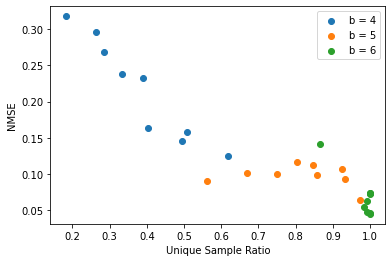

In [62]:
for i, b in enumerate(b_list):
    s_values = np.mean(unique_sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_values =  np.mean(nmses[:, :, i, :], axis=-1).flatten()

    plt.scatter(s_values, mse_values, label = "b = {}".format(b))

plt.xlabel('Unique Sample Ratio')
plt.ylabel('NMSE')
plt.legend()
plt.show()

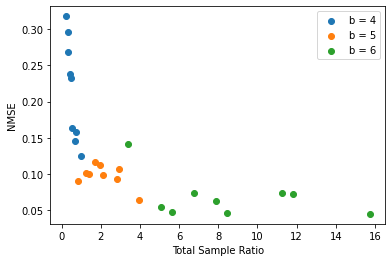

In [63]:
for i, b in enumerate(b_list):
    s_values = np.mean(sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_values =  np.mean(nmses[:, :, i, :], axis=-1).flatten()

    plt.scatter(s_values, mse_values, label = "b = {}".format(b))

plt.xlabel('Total Sample Ratio')
plt.ylabel('NMSE')
plt.legend()
plt.show()

### compare indices with most energy

In [ ]:
beta_power = np.abs(emp_beta_gwht) ** 2
for _ in range(30):
    ind = beta_power.argmax()
    print(beta_power[ind], np.array(dec_to_qary_vec([ind], n = n, q=q))[:, 0])
    beta_power[ind] = 0

In [ ]:
beta_power = np.abs(emp_beta_qspright) ** 2
for _ in range(30):
    ind = beta_power.argmax()
    print(beta_power[ind], np.array(dec_to_qary_vec([ind], n = n, q=q))[:, 0])
    beta_power[ind] = 0